<a href="https://colab.research.google.com/github/rahiakela/computer-vision-research-and-practice/blob/main/03-image-vision/01_classification_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification with Transfer Learning

In this notebook, we will discuss how to create an embedding (as distinct from a classification model), and how to use the embedding to train models on different datasets using two different approaches, transfer learning and fine-tuning.

Traditional fully connected neural network layers perform poorly on
images because they do not take advantage of the fact that adjacent pixels are highly correlated.

<img src='images/1.png?raw=1' width='800'/>

>Applying a fully connected layer to all the pixels of an image treats the pixels as independent inputs and ignores that images have adjacent pixels working together to create shapes.

Moreover, fully connecting multiple layers does not make any special provisions for the 2D hierarchical nature of images. Pixels close to each other work together to create shapes (such as lines and arcs), and these shapes themselves
work together to create recognizable parts of an object (such as the stem and
petals of a flower).



## Setup

In [ ]:
!pip install --quiet keras-tuner

     |████████████████████████████████| 97 kB 3.7 MB/s 


In [1]:
import tensorflow as tf

print(tf.version.VERSION)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.6.0
Found GPU at: /device:GPU:0


In [7]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os

In [3]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(model, filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);
    ax[flower].axis('off')

In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
print("These are the available classes:", CLASS_NAMES)

# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
!gsutil cat gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv | head -20

##Pretrained Embeddings

In some sense, all the information contained in
the input image is being represented by the penultimate layer, whose output consists of 16 numbers. These 16 numbers that provide a representation of the image are called an embedding. Of course, earlier layers also capture information from the input image, but those are typically not used as embeddings because they are missing some of the hierarchical information.

<img src='images/2.png?raw=1' width='800'/>

##Pretrained Model

What if we were to repurpose the embedding creation part from a model that
has been trained on a much larger dataset?

We can’t repurpose the whole model, because that model will not have been trained to classify flowers. However, we can throw away the last layer, or prediction head, of that model and replace it with our own. The repurposed part of the model can be pretrained from a very large, generalpurpose
dataset and the knowledge can then be transferred to the actual dataset that
we want to classify.

Pretrained models are models that are trained on large datasets and made available to be used as a way to create embeddings.

As long as the images we want to classify are similar in nature to the ones that MobileNet was trained on, the embeddings from MobileNet should give us a great pretrained embedding that we can use as a starting point to train a model on our own smaller dataset.

Let's load a pre-trained model and use it instead of the Flattened layer as our first layer.

In [10]:
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

def train_and_evaluate(batch_size=32, lrate=0.001, l1=0.0, l2=0.0, num_hidden=16):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").map(decode_csv)).batch(batch_size)
  eval_dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").map(decode_csv)).batch(32)  # this doesn't matter

  layers = [
            hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                          trainable=False,
                          name="mobilenet_embedding"),
            tf.keras.layers.Dense(num_hidden, kernel_regularizer=regularizer, activation="relu", name="dense_hidden"),
            tf.keras.layers.Dense(len(CLASS_NAMES), kernel_regularizer=regularizer, activation="softmax", name="flower_prob")
          ]

  model = tf.keras.Sequential(layers, name="flower_classification")
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate), 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=["accuracy"])
  print(model.summary())

  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=5)
  training_plot(["loss", "accuracy"], history)

  return model

Critically, we specify that this layer is not trainable, and should be assumed to be pretrained. By doing so, we ensure that its weights will not be modified based on the flowers data; it will be read-only.

Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_embedding (KerasLa (None, 1280)              2257984   
_________________________________________________________________
dense_hidden (Dense)         (None, 16)                20496     
_________________________________________________________________
flower_prob (Dense)          (None, 5)                 85        
Total params: 2,278,565
Trainable params: 20,581
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/5
104/104 [==============================] - 171s 1s/step - loss: 0.6606 - accuracy: 0.7773 - val_loss: 0.4130 - val_accuracy: 0.8541
Epoch 2/5
104/104 [==============================] - 109s 1s/step - loss: 0.3043 - accuracy: 0.8948 - val_loss: 0.3597 - val_accuracy: 0.8784
Epoch 3/5
104/104 [==============================] - 112s 1s/step - los

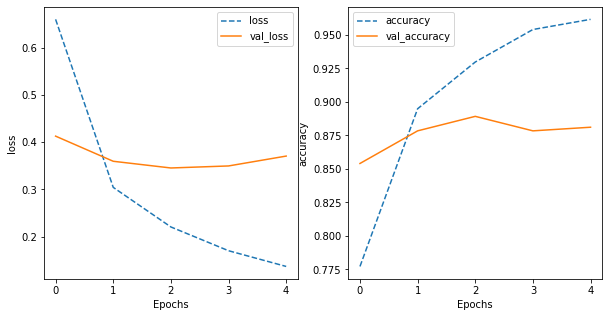

In [11]:
model = train_and_evaluate()

This process of training a model by replacing its input layer with an image embedding is called transfer learning, because we have transferred the knowledge learned from a much larger dataset by the MobileNet creators to our problem.



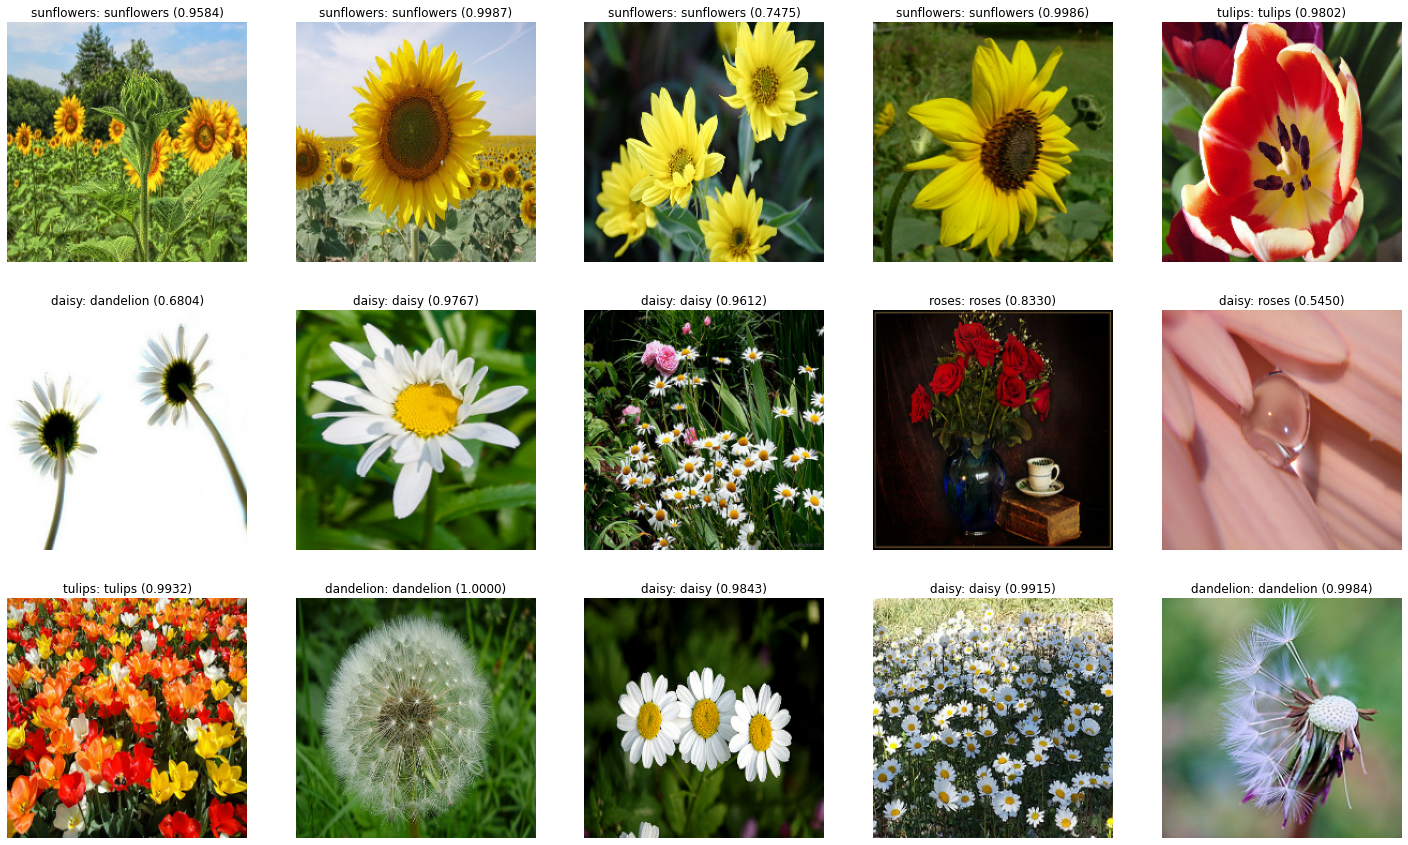

In [12]:
plot_predictions(model, "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv")

Rather impressively, we get an accuracy of 0.9 using transfer learning, whereas we got to only 0.48 when training a fully connected deep neural network from scratch on our data.

Transfer learning is what we recommend any time your
dataset is relatively small. Only when your dataset starts to exceed about five thousand images per label should you start to consider training from scratch.